# Phase 3 Data Science Training Notebook

In [2]:
import pandas as pd
import numpy as np

## Exploratory Data Analysis

In [9]:
# Assume tar.gz file to be extracted at project directory.
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
train_batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
train_batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
train_batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
train_batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
train_batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch = unpickle('cifar-10-batches-py/test_batch')

In [11]:
train_batches = [train_batch_1, train_batch_2, train_batch_3, train_batch_4, train_batch_5]
data_batches = train_batches + [test_batch]

In [12]:
for batch in data_batches:
    batch[b'data'] = np.reshape(batch[b'data'],(10000,3,32,32))
    batch[b'data'] = np.moveaxis(batch[b'data'],1,-1)

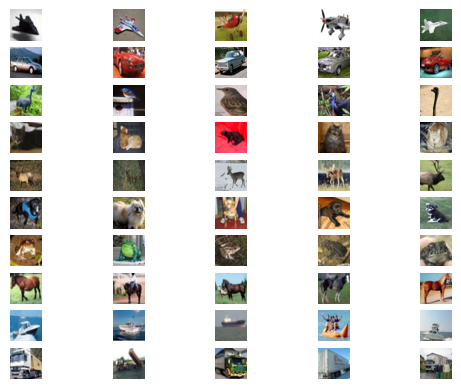

In [13]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(nrows=10, ncols=5)

for i in range(10):
    count = 0
    j = 0
    while count < 5:
        if train_batch_1[b'labels'][j] == i:
            axs[i][count].imshow(train_batch_1[b'data'][j])
            axs[i][count].axis('off')
            count += 1
        j += 1


# Data Processing

In [ ]:
train_x = np.random.randint(0,255,size=(10000,3,32,32))
train_y = np.random.randint(0,255,size=(10000))

test_x = np.random.randint(0,255,size=(1000,3,32,32))
test_y = np.random.randint(0,255,size=(1000))

# Data Modelling

In [5]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks
from datetime import datetime

In [ ]:
def generateModel():
    """
    Make a Keras Sequential Model.
    Feel free to change the layout of the layers.

    Read more about keras here: https://keras.io/api/
    Tensorflow setup adapted here: https://www.tensorflow.org/tutorials/quickstart/beginner
    """
    model = Sequential(name="Image_Recognition_Model")
    model.add(Input(shape=(3,32,32))) # Input layer.

    model.add(layers.Rescaling(scale=1./255, name="Normaliser")) # Example pre-processing layer.

    model.add(layers.Dense(40, activation="relu")) # Example Hidden Layer 1. Has 40 Nodes.
    model.add(layers.Dense(25, activation="sigmoid")) # Example Hidden Layer 2. Has 25 Nodes.
    model.add(layers.Dense(15, activation="tanh")) # Example Hidden Layer 3. Has 15 Nodes.

    model.add(layers.Dense(1, activation="sigmoid", name="Output_Probability")) # Output layer.

    model.compile(
        optimizer=optimizers.SGD(learning_rate=0.01),
        loss=losses.MeanAbsoluteError(),
        metrics=['accuracy']
    )

    return model

In [ ]:
model = generateModel()

log_dir = "output/logs/" + datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

# Callbacks for QoL.
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystop_callback = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.fit(train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=50000,
    batch_size=1000, # Set this to a lower number if your computer spec is bad.
    callbacks=[tensorboard_callback, earlystop_callback],
    # verbose=0 # Uncomment this line to reduce the printing on console.
)

In [ ]:
model.save('output/my_model')